# **Bibliotecas**

In [ ]:
%%capture

!pip install shap
!pip install optuna

In [ ]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

# **Funções**

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [ ]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [ ]:
# Baixando todos os arquivos dos tipos de câncer
!gdown 1gCvb72254hSgR3uRDNnkuvypdKMDXE-E --quiet # Colorretal
!gdown 1-5TMUdCHgLEBig1F5a4rRuTT5MdT4Lrw --quiet # Pulmão
!gdown 1-AY70uv61sBGJbUFCiF8Igyes3eP6ymm --quiet # Mama
!gdown 1-ApWhBLZG4NdOtLiwlaYflR2EzTB5vV8 --quiet # Colo de Útero
!gdown 1-HKn3Rk1i9hRAK06khtSF9lf9bInZ3HS --quiet # Próstata
!gdown 1-PJi2-Tu6-AD9PVmVb5Pbx3IzVy8vnr3 --quiet # Pele

In [ ]:
# Leitura dos dados de colo de útero
df_pulmao = pd.read_csv('pulmao.csv')
print(df_pulmao.shape)
df_pulmao.head(3)

(38646, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3520103,9,1,C340,C34,IIIB,J,1,...,13,3505500,2,2.0,0,0,1,0,0,0
1,28,2,3554508,9,1,C340,C34,IIIB,C,0,...,8,3525300,2,3.0,0,1,1,1,0,0
2,27,2,3507001,2,2,C340,C34,IV,F,0,...,8,3525300,2,4.0,0,0,1,0,0,0


In [ ]:
# Valores faltantes
df_pulmao.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [ ]:
df_pulmao_ano1 = df_pulmao[~((df_pulmao.obito_geral == 0) & (df_pulmao.sobrevida_ano1 == 0))].reset_index(drop=True)
df_pulmao_ano1.head(3)

,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3520103,9,1,C340,C34,IIIB,J,1,...,13,3505500,2,2.0,0,0,1,0,0,0
1,28,2,3554508,9,1,C340,C34,IIIB,C,0,...,8,3525300,2,3.0,0,1,1,1,0,0
2,27,2,3507001,2,2,C340,C34,IV,F,0,...,8,3525300,2,4.0,0,0,1,0,0,0


In [ ]:
# Correlação com a saída
corr_matrix = df_pulmao_ano1.corr()
abs(corr_matrix['sobrevida_ano1']).sort_values(ascending = False).head(20)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


sobrevida_ano1      1.000000
sobrevida_ano3      0.466865
obito_geral         0.387284
sobrevida_ano5      0.315864
presenca_rec        0.306025
TRATCONS            0.287508
DIAGTRAT            0.287463
NENHUM              0.283447
CIRURGIA            0.247663
QUIMIO              0.197310
RADIO               0.102746
SEXO                0.088913
ESCOLARI_preench    0.086624
CONSDIAG            0.084147
CATEATEND           0.075809
IMUNO               0.048324
IBGEATEN            0.046210
ANODIAG             0.045491
IDADE               0.039099
OUTROS              0.034469
Name: sobrevida_ano1, dtype: float64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df_pulmao_ano1.sobrevida_ano1.value_counts()

0    22687
1    15124
Name: sobrevida_ano1, dtype: int64

## **Pré-processamento**

In [ ]:
df_pulmao.columns

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'TOPO', 'TOPOGRUP',
       'EC', 'TRATHOSP', 'NENHUM', 'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO',
       'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG',
       'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2', 'ESCOLARI_preench',
       'IBGE_idem_IBGEATEN', 'presenca_rec', 'obito_geral', 'sobrevida_ano1',
       'sobrevida_ano3', 'sobrevida_ano5'],
      dtype='object')

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano3', 'sobrevida_ano5']

lb = 'sobrevida_ano1'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_pulmao_ano1,
                                                                       list_drop, lb,
                                                                    #    ohe_encoder=['TRATHOSP'],
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (28358, 25), X_test = (9453, 25)
y_train = (28358,), y_test = (9453,)


In [ ]:
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'NENHUM',
       'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS',
       'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS',
       'IBGEATEN', 'HABILIT2', 'ESCOLARI_preench', 'IBGE_idem_IBGEATEN',
       'presenca_rec'],
      dtype='object')

In [ ]:
y_train.value_counts(normalize=True)

0    0.600007
1    0.399993
Name: sobrevida_ano1, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

0    0.600021
1    0.399979
Name: sobrevida_ano1, dtype: float64

# **Treinamento e validação dos modelos de machine learning**

## **Random Forest**


### **Modelo Base**

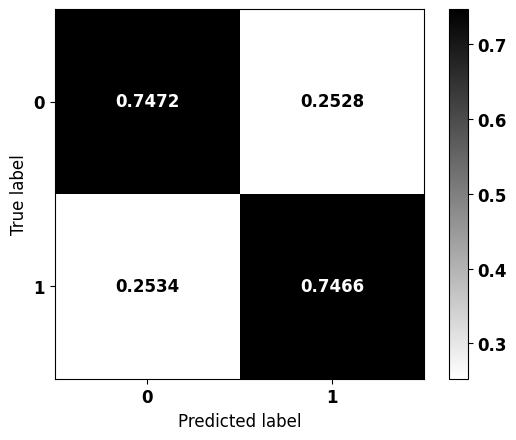


              precision    recall  f1-score   support

           0     0.8156    0.7472    0.7799      5672
           1     0.6631    0.7466    0.7024      3781

    accuracy                         0.7470      9453
   macro avg     0.7394    0.7469    0.7412      9453
weighted avg     0.7546    0.7470    0.7489      9453



In [ ]:
# Criação e treinamento do modelo Random Forest
rf = RandomForestClassifier(random_state=seed,
                            class_weight={0:1, 1:1.5909},
                            max_depth=9,
                            criterion='entropy')

rf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(rf, X_test, y_test)

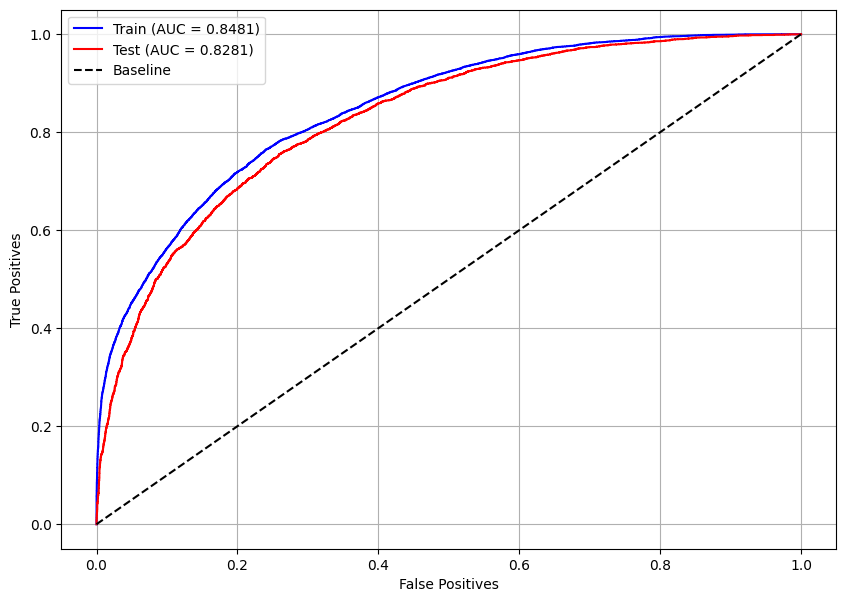

In [ ]:
# Curva ROC
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


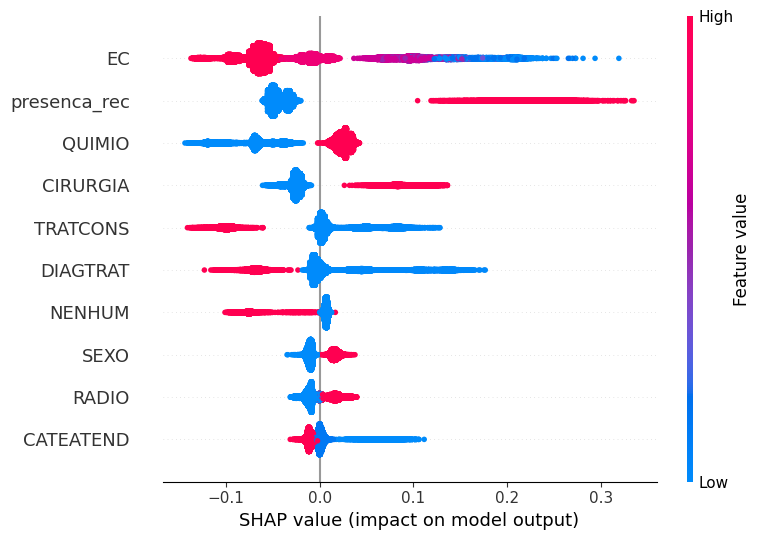

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(rf, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 9)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    max_samples = trial.suggest_float('max_samples', 0.7, 1.0, step=0.1)
    # optimizer = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cls = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples,
                                #  criterion=optimizer,
                                 random_state=seed,
                                 n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=RandomSampler(seed),
                              study_name='pulmao_rf')
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyRF.best_trial

FrozenTrial(number=58, state=TrialState.COMPLETE, values=[0.7545313716564304], datetime_start=datetime.datetime(2023, 10, 11, 12, 51, 14, 521868), datetime_complete=datetime.datetime(2023, 10, 11, 12, 51, 45, 624948), params={'n_estimators': 95, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_samples': 0.7, 'criterion': 'gini'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=9, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=7, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.7, step=0.1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=58, value=None)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 95,
 'max_depth': 9,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_samples': 0.7,
 'criterion': 'gini'}

In [ ]:
pesos = np.round(np.arange(1.55, 1.65, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:1, 1:i}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

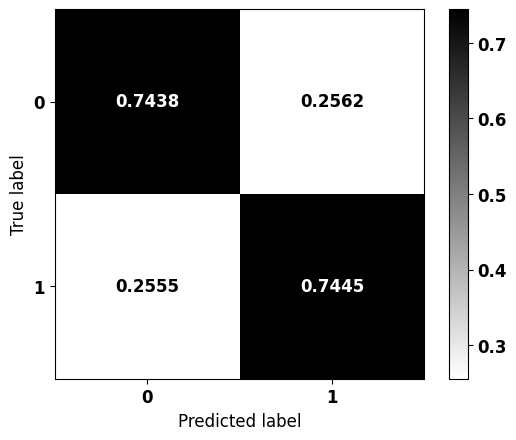


              precision    recall  f1-score   support

           0     0.8137    0.7438    0.7772      5672
           1     0.6596    0.7445    0.6995      3781

    accuracy                         0.7441      9453
   macro avg     0.7366    0.7442    0.7383      9453
weighted avg     0.7520    0.7441    0.7461      9453



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.6}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

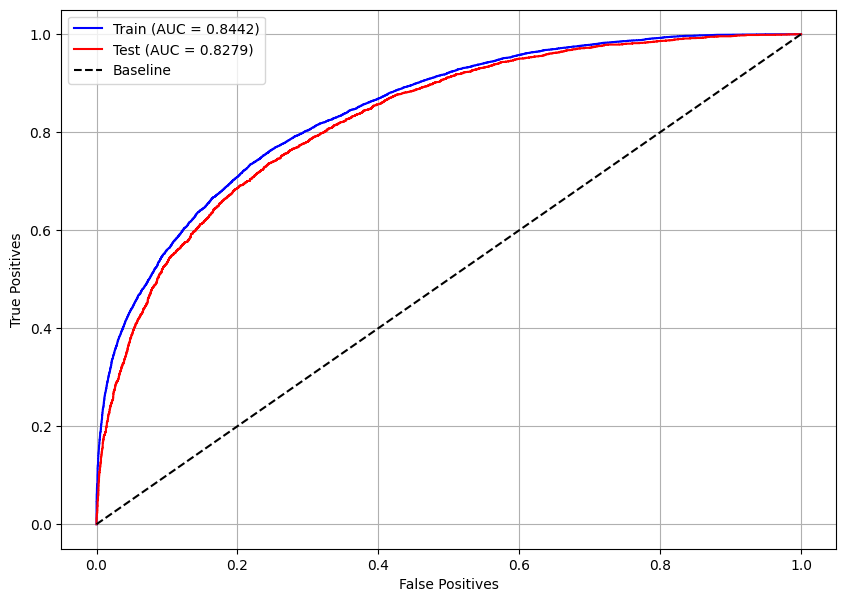

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 144,
 'max_depth': 9,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_samples': 0.8999999999999999,
 'criterion': 'gini'}

In [ ]:
pesos = np.round(np.arange(1.55, 1.65, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:1, 1:i}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

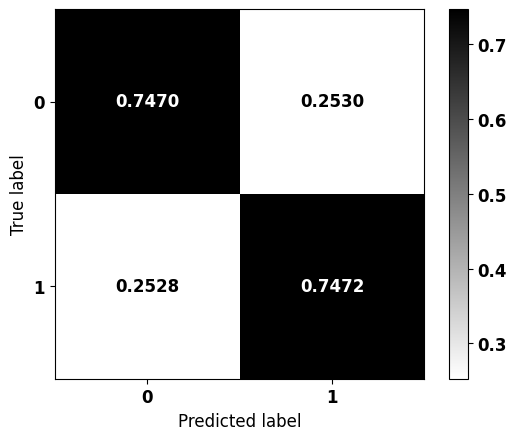


              precision    recall  f1-score   support

           0     0.8159    0.7470    0.7799      5672
           1     0.6631    0.7472    0.7026      3781

    accuracy                         0.7471      9453
   macro avg     0.7395    0.7471    0.7413      9453
weighted avg     0.7548    0.7471    0.7490      9453



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.625}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

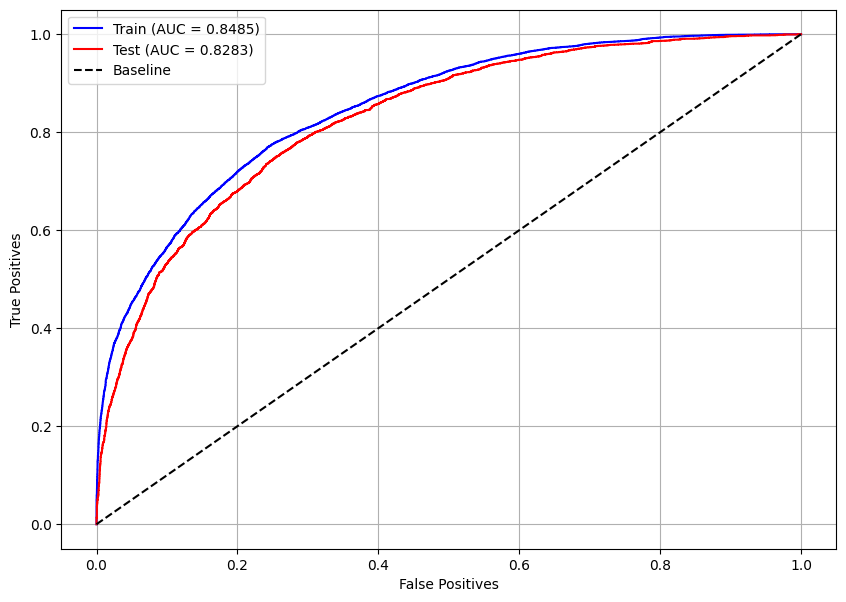

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 117,
 'max_depth': 9,
 'min_samples_split': 8,
 'min_samples_leaf': 5,
 'max_samples': 0.7}

In [ ]:
pesos = np.round(np.arange(1.55, 1.65, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:1, 1:i}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

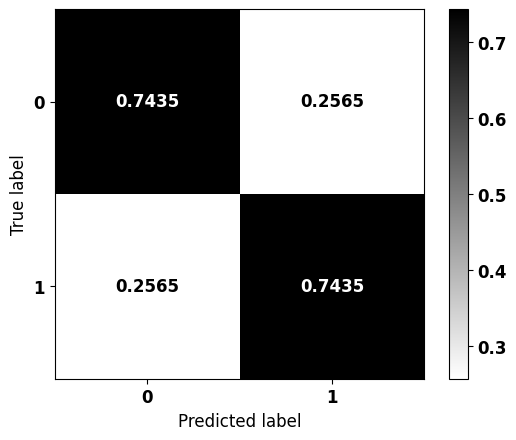


              precision    recall  f1-score   support

           0     0.8130    0.7435    0.7767      5672
           1     0.6589    0.7435    0.6986      3781

    accuracy                         0.7435      9453
   macro avg     0.7360    0.7435    0.7377      9453
weighted avg     0.7514    0.7435    0.7455      9453



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.603}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

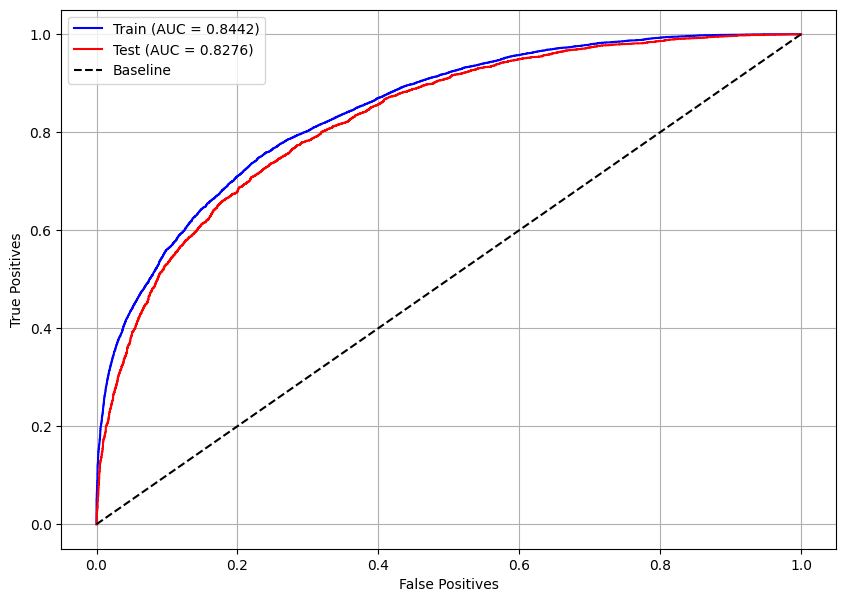

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

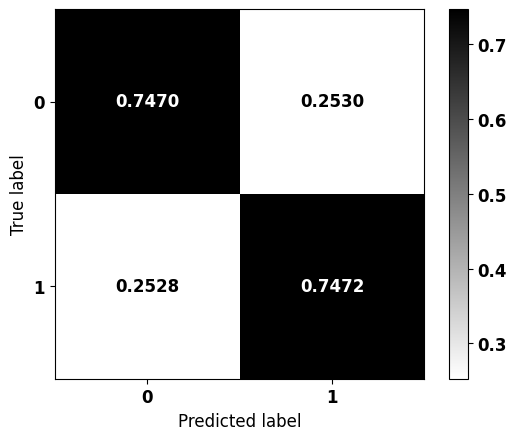


              precision    recall  f1-score   support

           0     0.8159    0.7470    0.7799      5672
           1     0.6631    0.7472    0.7026      3781

    accuracy                         0.7471      9453
   macro avg     0.7395    0.7471    0.7413      9453
weighted avg     0.7548    0.7471    0.7490      9453



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 144, 'max_depth': 9, 'min_samples_split': 7,
          'min_samples_leaf': 1, 'max_samples': 0.9, 'criterion': 'gini'}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.625}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

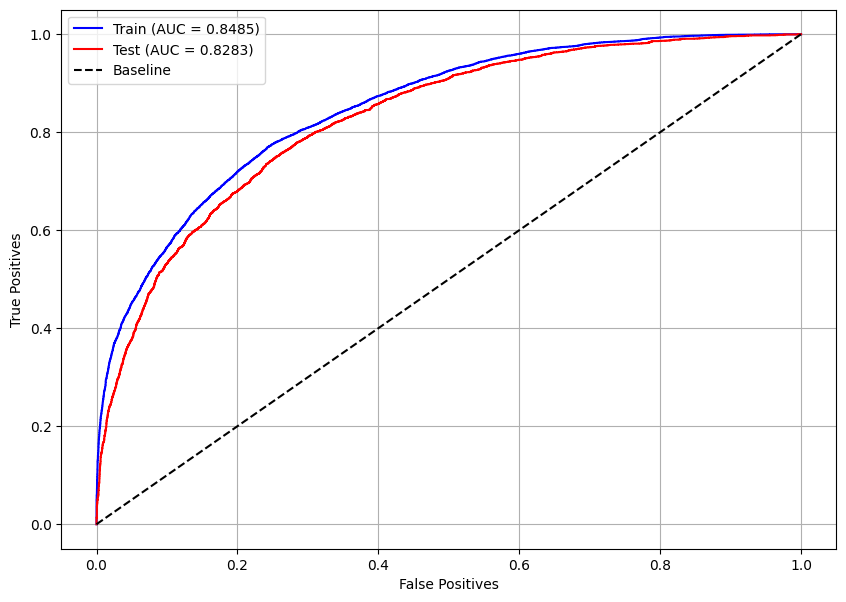

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

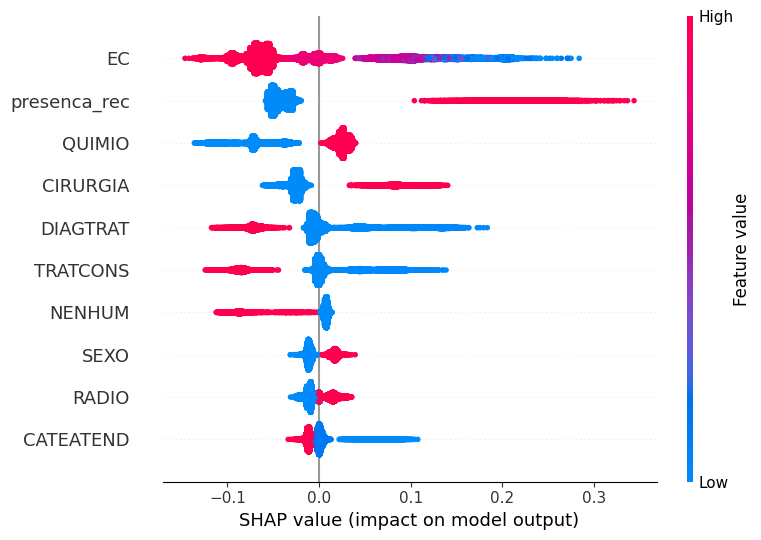

In [ ]:
# Importância das features pelos valores SHAP do modelo otimizado
plot_shap_values(rf_optuna, X_train, feat_cols)

## **XGBoost**


### **Modelo Base**

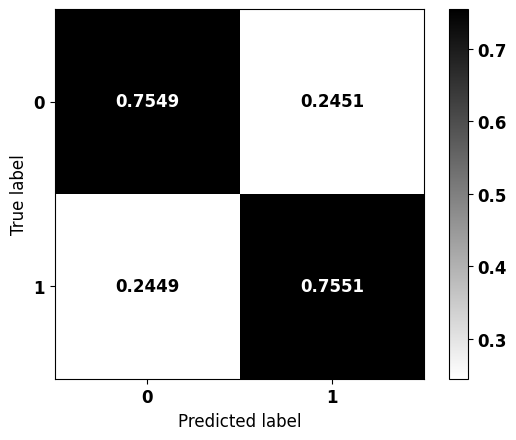


              precision    recall  f1-score   support

           0     0.8222    0.7549    0.7871      5672
           1     0.6726    0.7551    0.7114      3781

    accuracy                         0.7550      9453
   macro avg     0.7474    0.7550    0.7493      9453
weighted avg     0.7623    0.7550    0.7569      9453



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=4,
                    scale_pos_weight=1.603,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

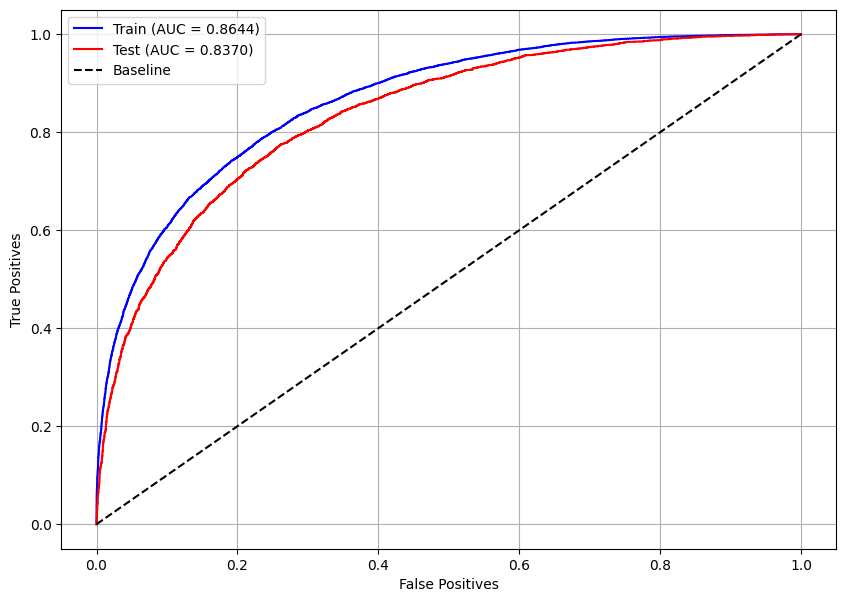

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

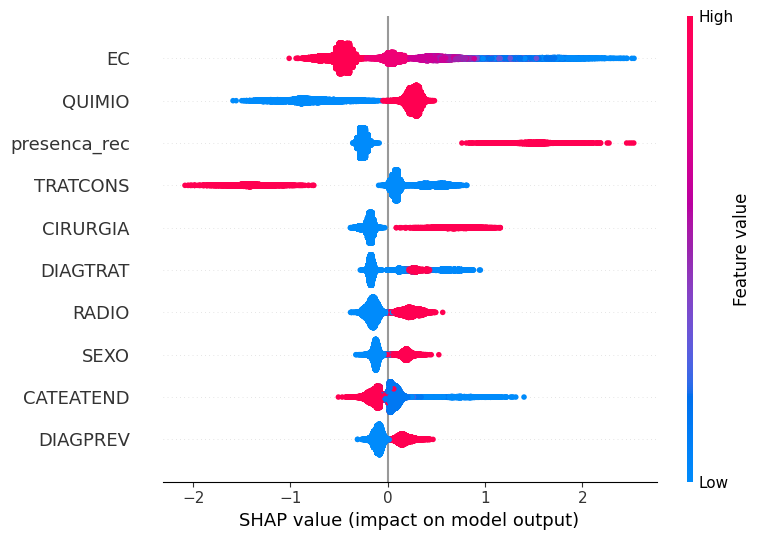

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed),
                               study_name='pulmao_xgb')
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyXGB.best_trial

FrozenTrial(number=58, state=TrialState.COMPLETE, values=[0.7626065103991762], datetime_start=datetime.datetime(2023, 10, 11, 15, 12, 53, 194839), datetime_complete=datetime.datetime(2023, 10, 11, 15, 13, 2, 660288), params={'n_estimators': 134, 'max_depth': 5, 'learning_rate': 0.15000000000000002, 'gamma': 0.0, 'min_child_weight': 5, 'colsample_bytree': 0.4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=6, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.05), 'gamma': FloatDistribution(high=0.3, log=False, low=0.0, step=0.1), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=58, value=None)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 134,
 'max_depth': 5,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.0,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.58, 1.6, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

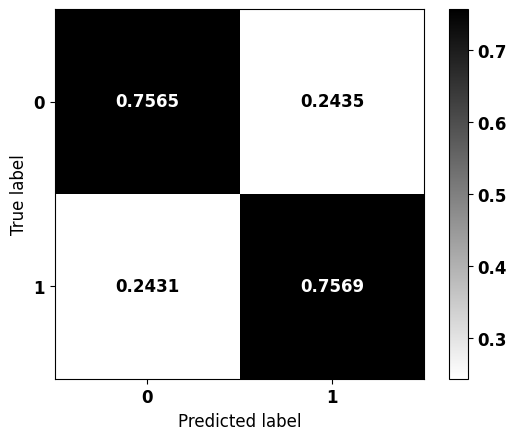


              precision    recall  f1-score   support

           0     0.8236    0.7565    0.7886      5672
           1     0.6745    0.7569    0.7134      3781

    accuracy                         0.7567      9453
   macro avg     0.7491    0.7567    0.7510      9453
weighted avg     0.7640    0.7567    0.7585      9453



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.587

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

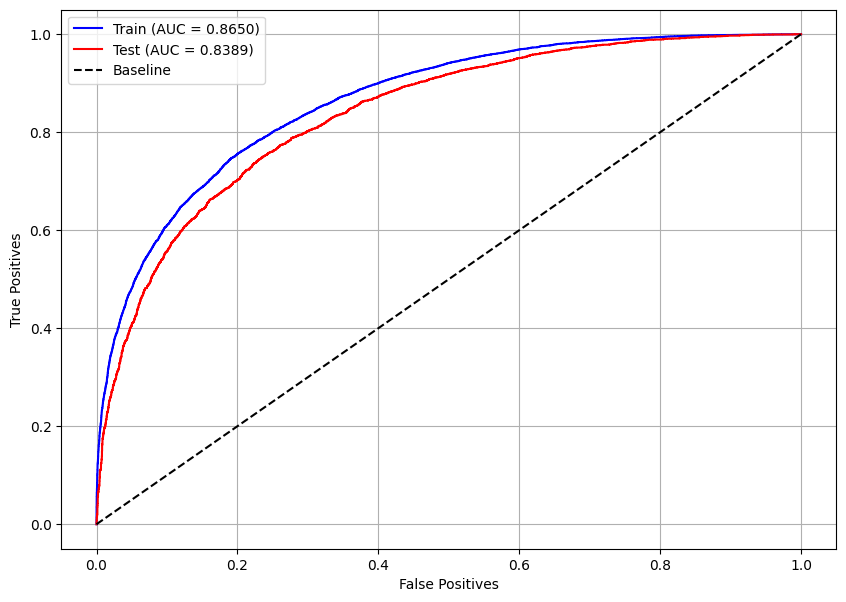

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 110,
 'max_depth': 5,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.2,
 'min_child_weight': 4,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(1.59, 1.61, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

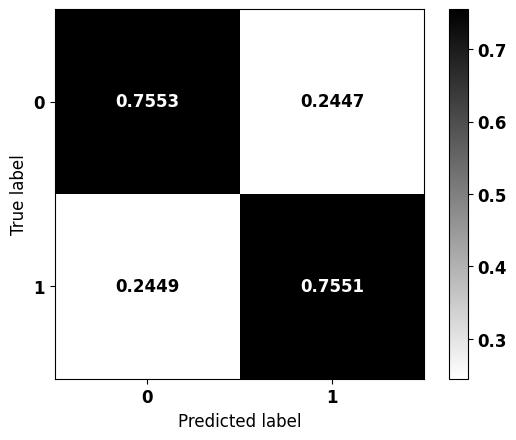


              precision    recall  f1-score   support

           0     0.8223    0.7553    0.7874      5672
           1     0.6729    0.7551    0.7116      3781

    accuracy                         0.7552      9453
   macro avg     0.7476    0.7552    0.7495      9453
weighted avg     0.7625    0.7552    0.7571      9453



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.6065

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

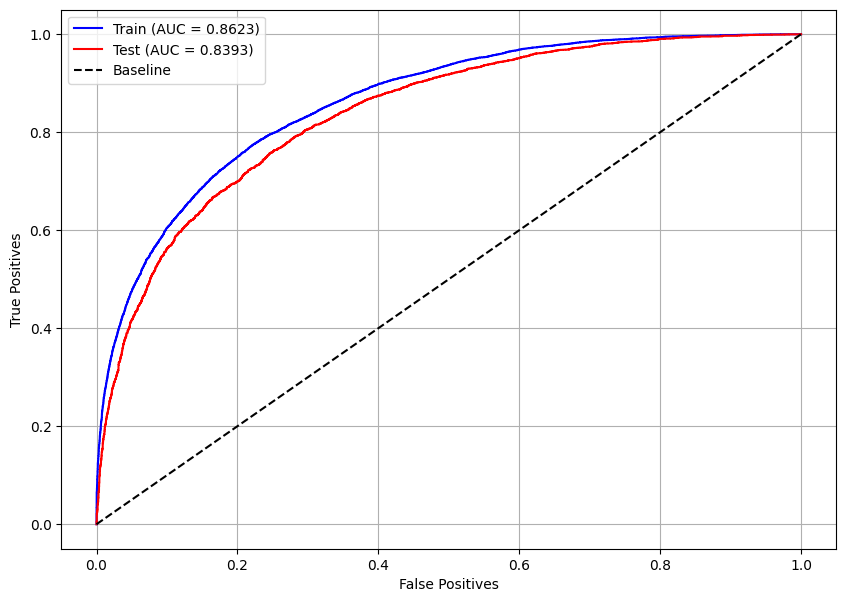

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 106,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 3,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.59, 1.61, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

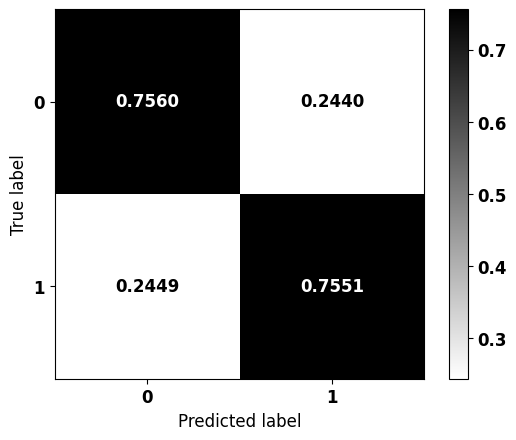


              precision    recall  f1-score   support

           0     0.8224    0.7560    0.7878      5672
           1     0.6735    0.7551    0.7120      3781

    accuracy                         0.7556      9453
   macro avg     0.7480    0.7555    0.7499      9453
weighted avg     0.7628    0.7556    0.7575      9453



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.6085

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

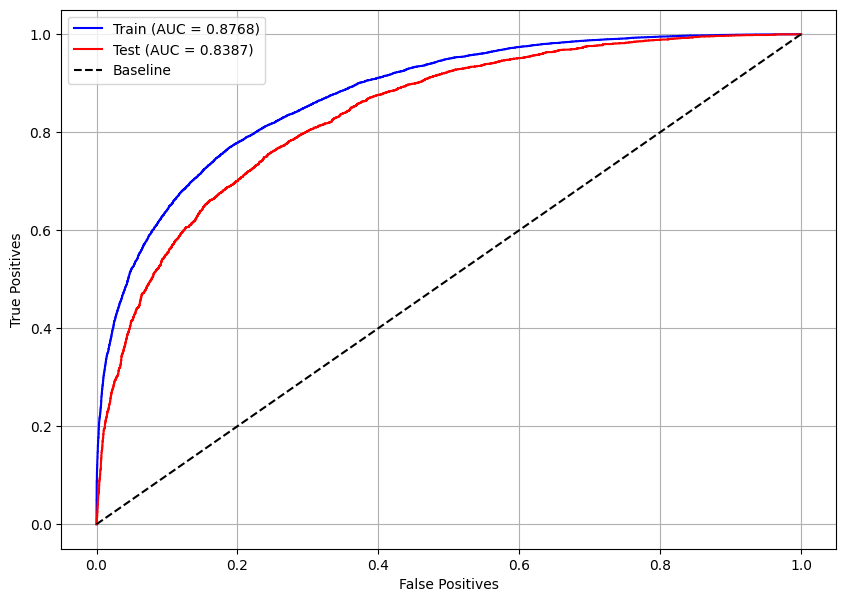

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

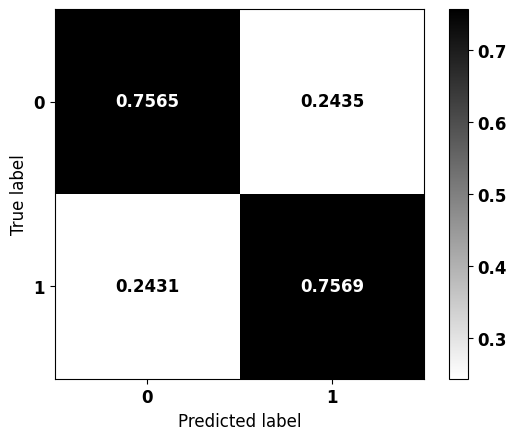


              precision    recall  f1-score   support

           0     0.8236    0.7565    0.7886      5672
           1     0.6745    0.7569    0.7134      3781

    accuracy                         0.7567      9453
   macro avg     0.7491    0.7567    0.7510      9453
weighted avg     0.7640    0.7567    0.7585      9453



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 134, 'max_depth': 5, 'learning_rate': 0.15,
          'gamma': 0.0, 'min_child_weight': 5, 'colsample_bytree': 0.4}

params['random_state'] = seed
params['scale_pos_weight'] = 1.587

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

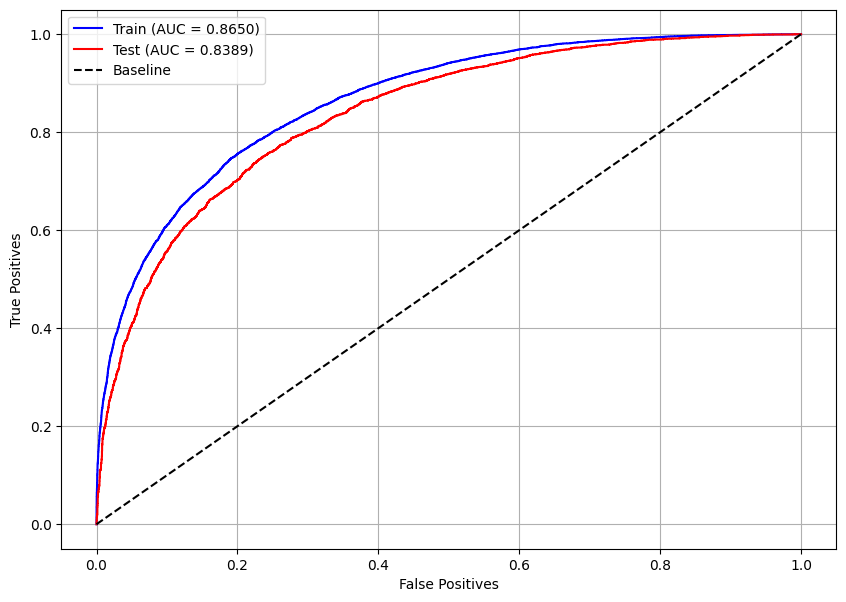

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

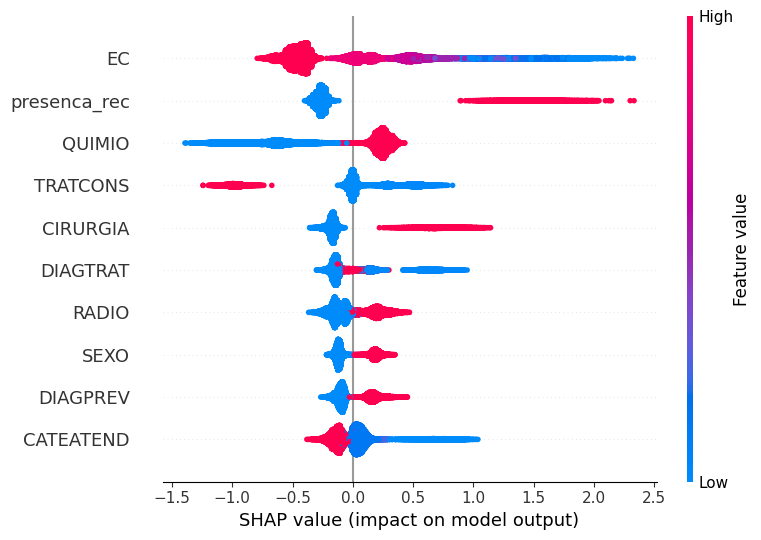

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

## **LightGBM**


### **Modelo Base**

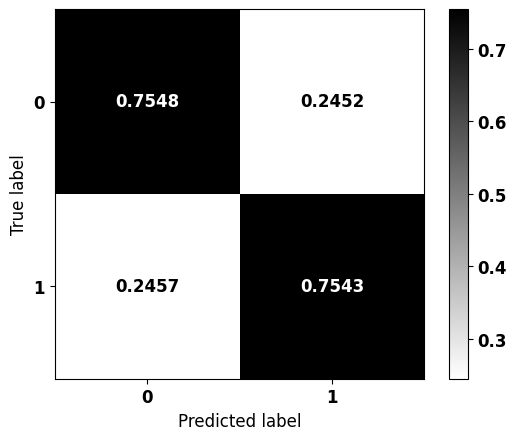


              precision    recall  f1-score   support

           0     0.8217    0.7548    0.7868      5672
           1     0.6722    0.7543    0.7109      3781

    accuracy                         0.7546      9453
   macro avg     0.7469    0.7545    0.7488      9453
weighted avg     0.7619    0.7546    0.7564      9453



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1, 1:1.524},
                      random_state=seed,
                      importance_type='gain',
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

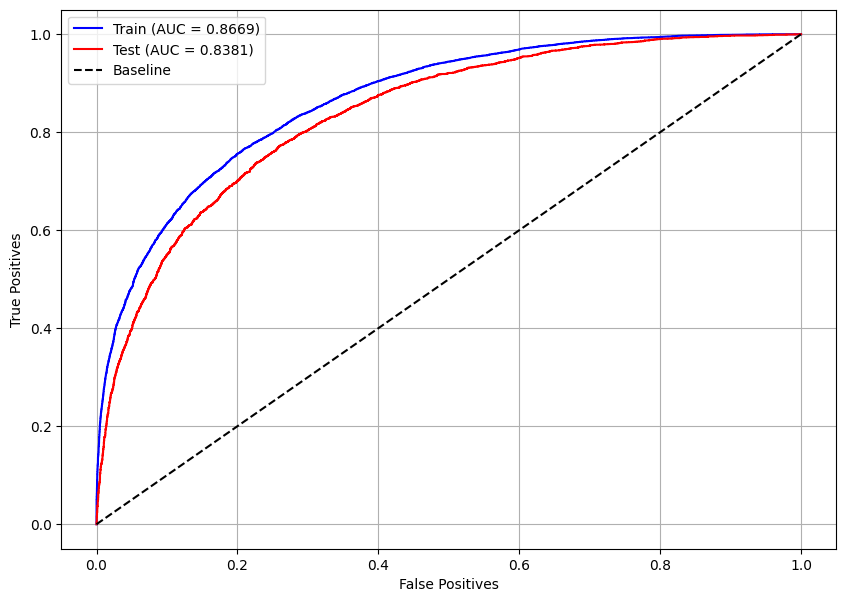

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

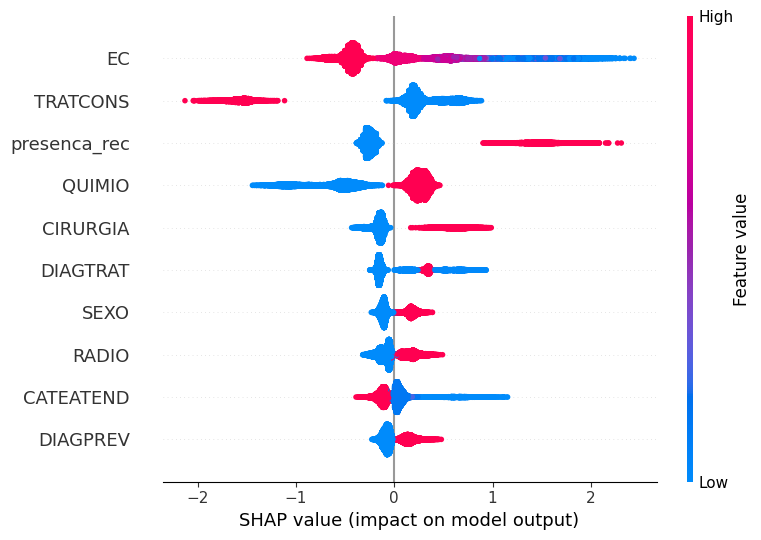

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed),
                                study_name='pulmao_lgbm')
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyLGBM.best_trial

FrozenTrial(number=15, state=TrialState.COMPLETE, values=[0.7631354119247866], datetime_start=datetime.datetime(2023, 10, 11, 15, 51, 30, 934650), datetime_complete=datetime.datetime(2023, 10, 11, 15, 51, 45, 174719), params={'n_estimators': 117, 'max_depth': 8, 'learning_rate': 0.09, 'min_child_weight': 3, 'colsample_bytree': 0.4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.01), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=15, value=None)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 117,
 'max_depth': 8,
 'learning_rate': 0.09,
 'min_child_weight': 3,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.53, 1.55, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

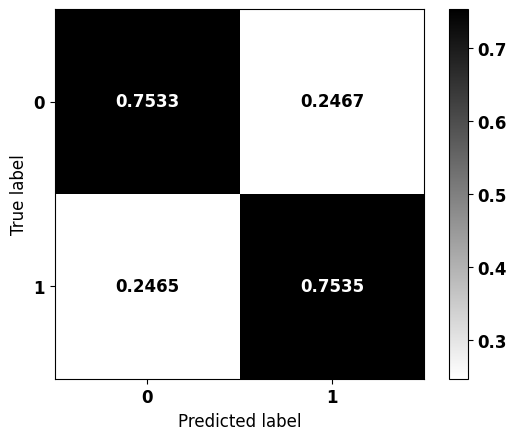


              precision    recall  f1-score   support

           0     0.8209    0.7533    0.7857      5672
           1     0.6707    0.7535    0.7097      3781

    accuracy                         0.7534      9453
   macro avg     0.7458    0.7534    0.7477      9453
weighted avg     0.7608    0.7534    0.7553      9453



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.5439}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

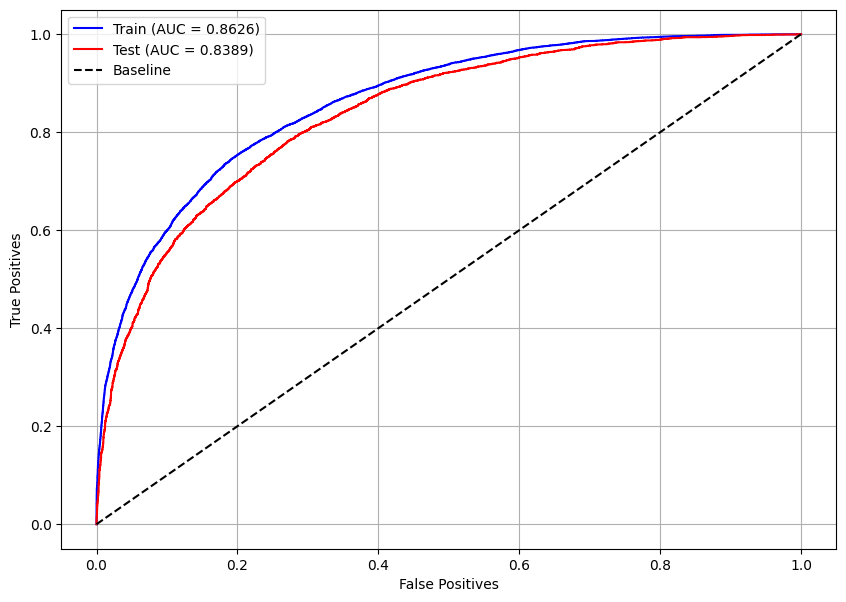

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 98,
 'max_depth': 8,
 'learning_rate': 0.15000000000000002,
 'min_child_weight': 4,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.55, 1.58, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

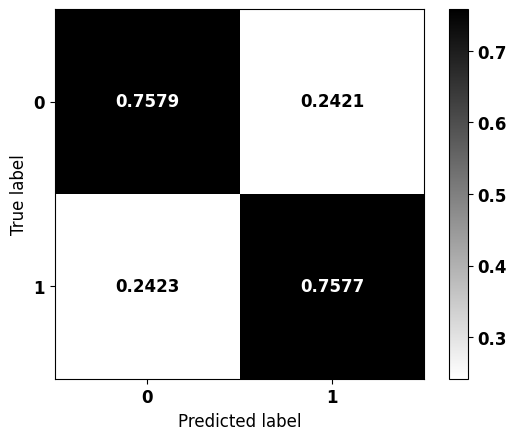


              precision    recall  f1-score   support

           0     0.8244    0.7579    0.7897      5672
           1     0.6760    0.7577    0.7146      3781

    accuracy                         0.7579      9453
   macro avg     0.7502    0.7578    0.7522      9453
weighted avg     0.7650    0.7579    0.7597      9453



In [ ]:
# Modelo com os melhores parâmetros
# params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.5579}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

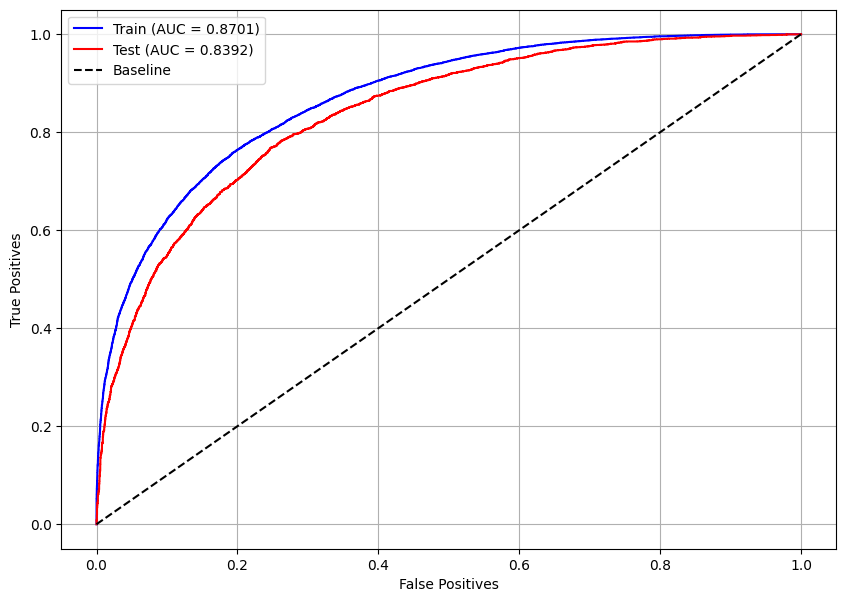

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 85,
 'max_depth': 8,
 'learning_rate': 0.14,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.54, 1.57, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

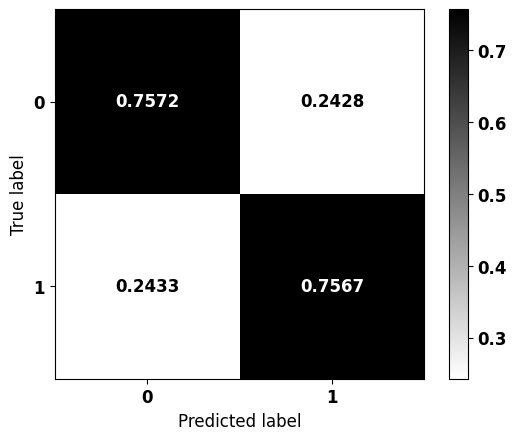


              precision    recall  f1-score   support

           0     0.8236    0.7572    0.7890      5672
           1     0.6751    0.7567    0.7136      3781

    accuracy                         0.7570      9453
   macro avg     0.7493    0.7570    0.7513      9453
weighted avg     0.7642    0.7570    0.7588      9453



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.5543}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

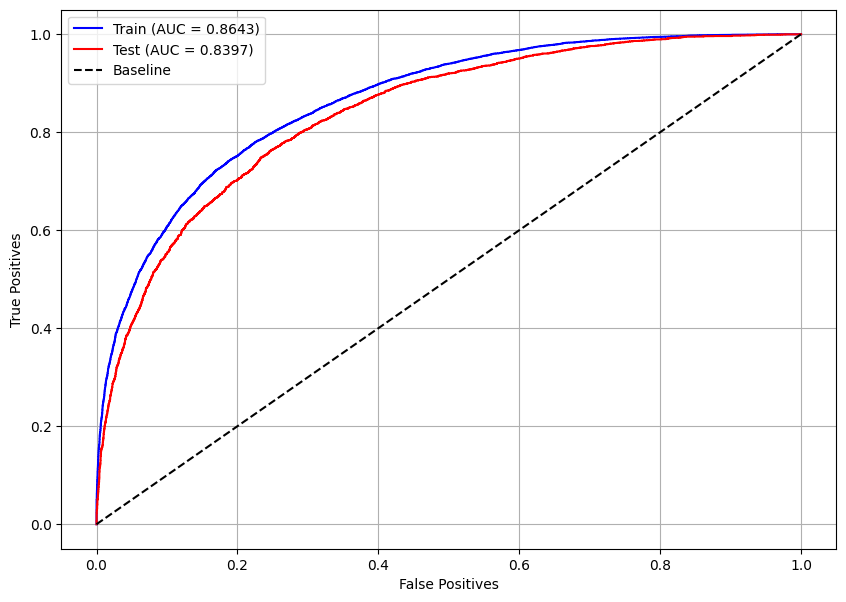

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

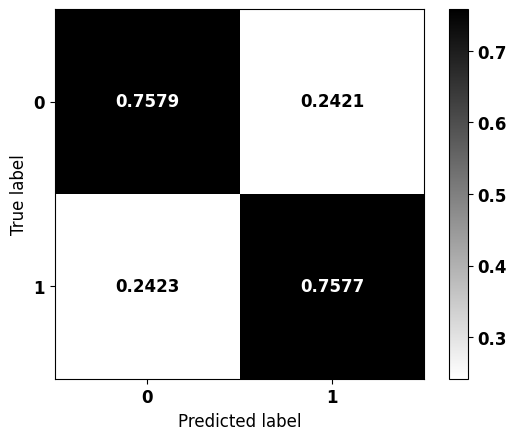


              precision    recall  f1-score   support

           0     0.8244    0.7579    0.7897      5672
           1     0.6760    0.7577    0.7146      3781

    accuracy                         0.7579      9453
   macro avg     0.7502    0.7578    0.7522      9453
weighted avg     0.7650    0.7579    0.7597      9453



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 98, 'max_depth': 8, 'learning_rate': 0.15,
          'min_child_weight': 4, 'colsample_bytree': 0.4}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.5579}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

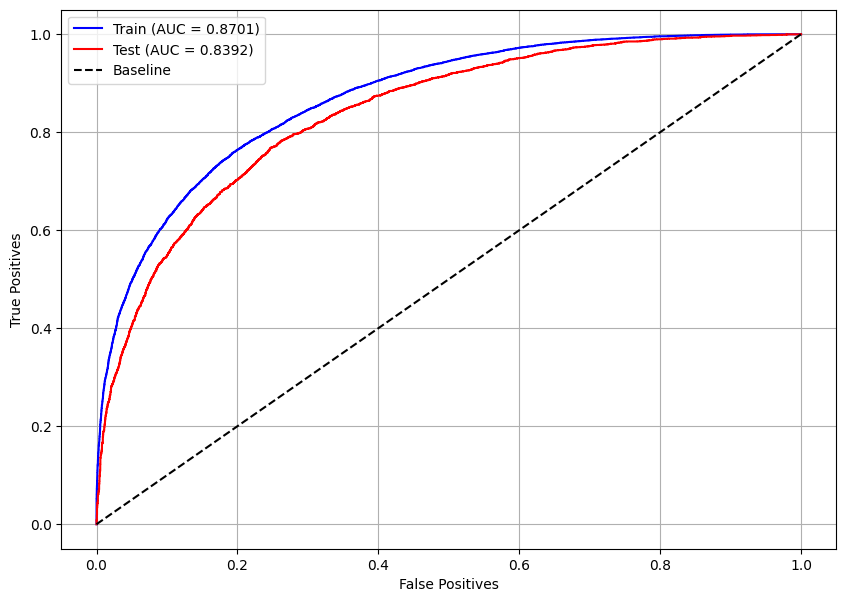

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


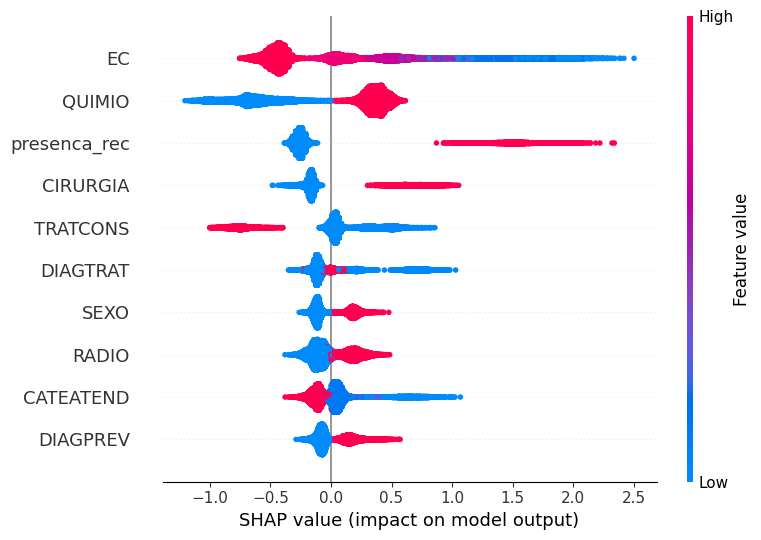

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo Random Forest
rf_score = rf.score(X_test, y_test)
optuna_score = rf_optuna.score(X_test, y_test)
print(f'Accuracy: RF = {rf_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= rf_score:
    params_rf = rf_optuna.get_params()
    print('Otimizado venceu')
else:
    params_rf = rf.get_params()
    print('Modelo inicial venceu')

Accuracy: RF = 0.7470, Optuna = 0.7471

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7550, Optuna = 0.7567

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7546, Optuna = 0.7579

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# Random Forest
best_rf = RandomForestClassifier()
best_rf.set_params(**params_rf)

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1, 1: 1.5579}, colsample_bytree=0.4,
               learning_rate=0.15, max_depth=8, min_child_weight=4,
               n_estimators=98, random_state=7, verbose=-1)

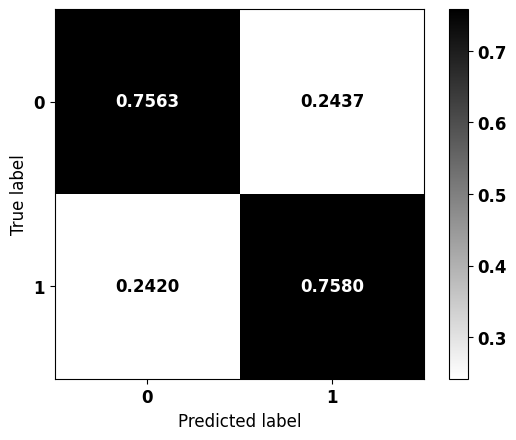


              precision    recall  f1-score   support

           0     0.8242    0.7563    0.7888      5672
           1     0.6747    0.7580    0.7139      3781

    accuracy                         0.7570      9453
   macro avg     0.7494    0.7572    0.7514      9453
weighted avg     0.7644    0.7570    0.7589      9453



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('RandomForest', best_rf),
                                   ('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

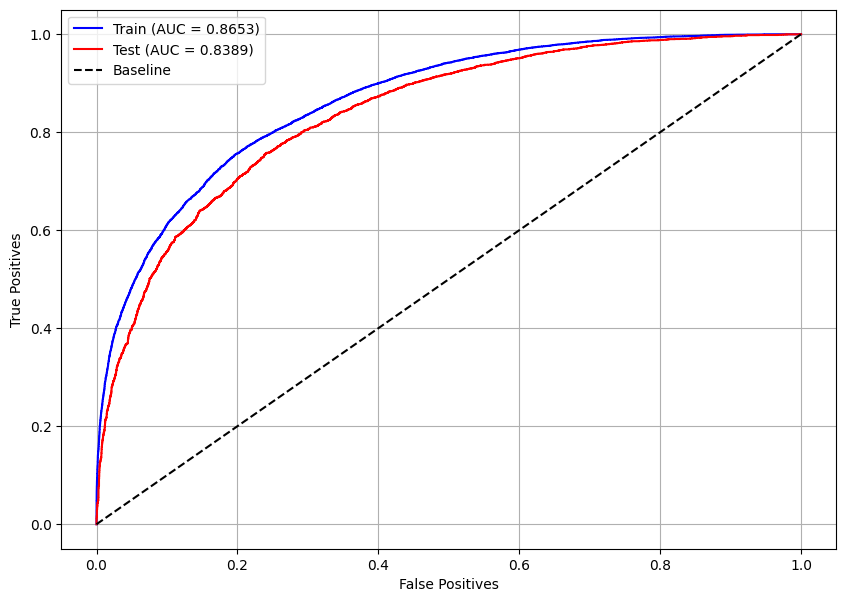

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [ ]:
# Melhor modelo
models = [rf, rf_optuna, xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1, 1: 1.5579}, colsample_bytree=0.4,
               learning_rate=0.15, max_depth=8, min_child_weight=4,
               n_estimators=98, random_state=7, verbose=-1)


In [ ]:
# Colunas que não serão utilizadas na predição cruzada
list_drop = list_drop + [lb]
list_drop

['TRATHOSP',
 'TOPO',
 'TOPOGRUP',
 'obito_geral',
 'sobrevida_ano3',
 'sobrevida_ano5',
 'sobrevida_ano1']

### **Colorretal**

In [ ]:
df_colorretal = pd.read_csv('/content/colorretal.csv')
print(df_colorretal.shape)
df_colorretal.head(3)

(60887, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3548708,9,1,C180,C18,III,E,0,...,1,3550308,1,3.0,0,0,1,1,0,0
1,26,2,3550308,9,1,C180,C18,III,A,0,...,6,3550308,2,2.0,1,0,0,1,1,1
2,22,2,3503208,9,2,C180,C18,IV,C,0,...,13,3503208,1,4.0,1,0,1,0,0,0


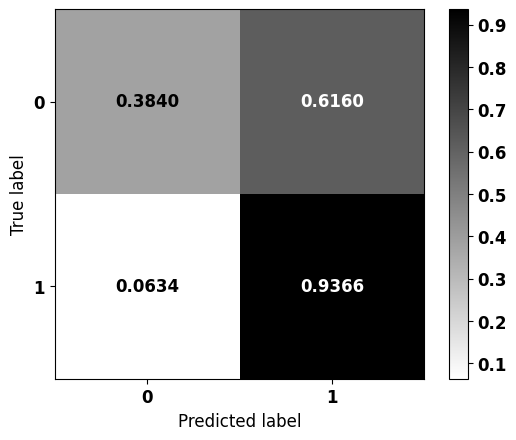


              precision    recall  f1-score   support

           0     0.6342    0.3840    0.4783     13079
           1     0.8416    0.9366    0.8866     45697

    accuracy                         0.8136     58776
   macro avg     0.7379    0.6603    0.6824     58776
weighted avg     0.7954    0.8136    0.7957     58776



In [ ]:
pred_cruzada(df_colorretal, best, list_drop, lb, enc, norm)

### **Mama**

In [ ]:
df_mama = pd.read_csv('/content/mama.csv')
print(df_mama.shape)
df_mama.head(3)

(117338, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,102,2,3550308,9,1,C509,C50,IIIB,D,0,...,6,3550308,2,3.0,1,1,1,1,0,0
1,28,2,3547809,9,2,C500,C50,I,G,0,...,1,3547809,1,4.0,1,0,1,1,1,1
2,27,2,3512001,2,2,C500,C50,I,H,0,...,13,3505500,2,4.0,0,1,0,1,1,1


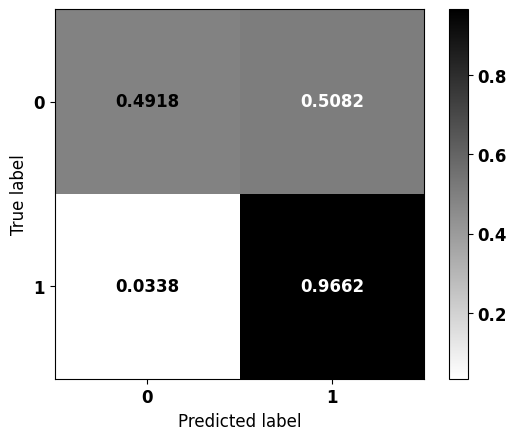


              precision    recall  f1-score   support

           0     0.4718    0.4918    0.4816      6546
           1     0.9687    0.9662    0.9674    106549

    accuracy                         0.9387    113095
   macro avg     0.7202    0.7290    0.7245    113095
weighted avg     0.9399    0.9387    0.9393    113095



In [ ]:
pred_cruzada(df_mama, best, list_drop, lb, enc, norm)

### **Colo de Útero**

In [ ]:
df_colo_utero = pd.read_csv('/content/colo_utero.csv')
print(df_colo_utero.shape)
df_colo_utero.head(3)

(23306, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,27,2,3548906,9,2,C530,C53,IIIB,B,0,...,13,3503208,1,4.0,0,0,1,1,0,0
1,29,2,3518701,9,1,C530,C53,IB2,E,0,...,7,3518701,1,3.0,1,0,1,1,0,0
2,29,2,3522109,2,2,C530,C53,IB1,A,0,...,7,3550308,2,3.0,0,1,0,1,1,1


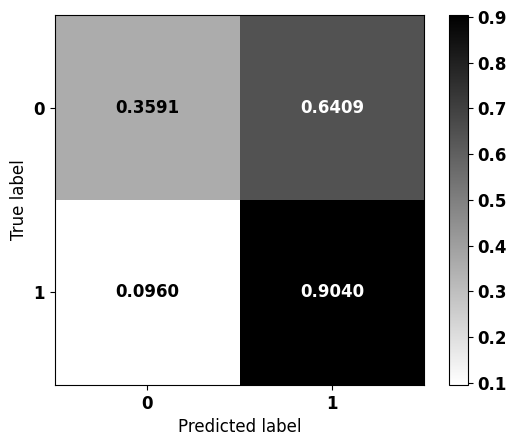


              precision    recall  f1-score   support

           0     0.4699    0.3591    0.4071      4300
           1     0.8561    0.9040    0.8794     18142

    accuracy                         0.7996     22442
   macro avg     0.6630    0.6315    0.6432     22442
weighted avg     0.7821    0.7996    0.7889     22442



In [ ]:
pred_cruzada(df_colo_utero, best, list_drop, lb, enc, norm)

### **Próstata**

In [ ]:
df_prostata = pd.read_csv('/content/prostata.csv')
print(df_prostata.shape)
df_prostata.head(3)

(94106, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,24,1,3524402,2,2,C619,C61,I,C,0,...,17,3524402,1,2.0,1,1,0,1,1,1
1,22,1,3519204,2,2,C619,C61,I,J,1,...,10,3555000,1,2.0,0,0,0,1,0,0
2,20,1,3502804,2,1,C619,C61,II,B,0,...,12,3502804,1,2.0,1,1,0,1,1,1


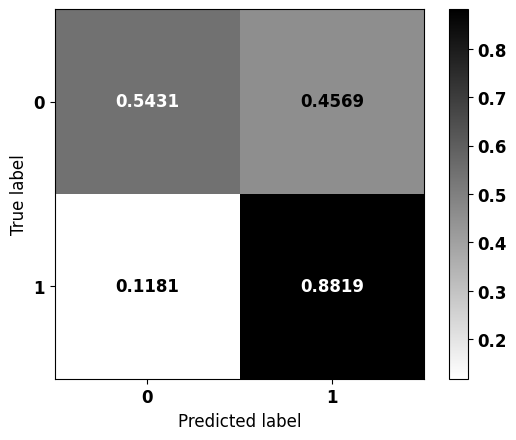


              precision    recall  f1-score   support

           0     0.1920    0.5431    0.2837      4421
           1     0.9739    0.8819    0.9256     85577

    accuracy                         0.8653     89998
   macro avg     0.5830    0.7125    0.6047     89998
weighted avg     0.9355    0.8653    0.8941     89998



In [ ]:
pred_cruzada(df_prostata, best, list_drop, lb, enc, norm)

### **Pele**

In [ ]:
df_pele = pd.read_csv('/content/pele.csv')
print(df_pele.shape)
df_pele.head(3)

(183164, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,101,2,3543402,9,1,C443,C44,I,I,0,...,13,3543402,2,2.0,1,0,1,1,0,0
1,100,1,3522802,2,1,C443,C44,II,A,0,...,9,3525300,2,1.0,0,0,1,1,0,0
2,105,2,3546603,9,1,C447,C44,I,A,0,...,12,3505500,2,1.0,0,0,1,0,0,0


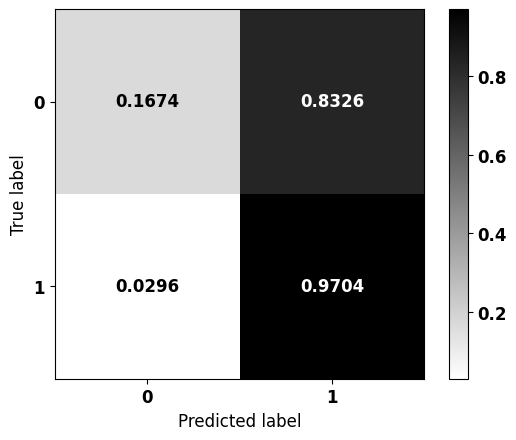


              precision    recall  f1-score   support

           0     0.2869    0.1674    0.2114      8108
           1     0.9424    0.9704    0.9562    113813

    accuracy                         0.9170    121921
   macro avg     0.6146    0.5689    0.5838    121921
weighted avg     0.8988    0.9170    0.9066    121921



In [ ]:
pred_cruzada(df_pele, best, list_drop, lb, enc, norm)